In [1]:
import cmocean
import xarray as xr 
import sys
import datacube
import numpy as np

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import DEAPlotting
import DEADataHandling
import SpatialTools


In [2]:
# Top End fires narrow
lat, lon = -14.85, 129.65
size, ratio = 0.18, 5
time_range = ('2018', '2018') 
product = 's2a_ard_granule'
resolution = (-50, 50)

# Compute window
lat_range = (lat - size, lat + size)
lon_range = (lon - (size * ratio), lon + (size * ratio)) 

# Plot area
DEAPlotting.display_map(y=lat_range, x=lon_range, crs='epsg:4326')


In [3]:
# Connect to datacube database
dc = datacube.Datacube(app='Time series animation')

# Create the 'query' dictionary object, which contains the longitudes, latitudes and time provided above
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'output_crs': 'EPSG:3577',
    'resolution': resolution
}

# Load data
s2_data = dc.load(product=product,
                  measurements=['nbar_red', 'nbar_green', 'nbar_blue'], 
                  group_by='solar_day',
                  dask_chunks={'time': 1},
                  **query).isel(time=-15).compute()

In [4]:
list_shifted = []

x_size = 1000

for i in range(0, len(s2_data.x) - x_size, 8):

    shifted_array = s2_data.shift(x=-i).isel(x=slice(0, x_size))
    list_shifted.append(shifted_array.astype(np.int16))
    
shifted_ds = xr.concat(list_shifted, dim='shift_x')
shifted_ds = shifted_ds.assign_coords(shift_x = shifted_ds.shift_x)


In [5]:
shifted_ds

<xarray.Dataset>
Dimensions:     (shift_x: 366, x: 1000, y: 862)
Coordinates:
    time        datetime64[ns] 2018-10-20T01:47:01.024000
  * y           (y) float64 -1.556e+06 -1.556e+06 ... -1.599e+06 -1.599e+06
  * x           (x) float64 -3.535e+05 -3.534e+05 ... -3.036e+05 -3.035e+05
  * shift_x     (shift_x) int64 0 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365
Data variables:
    nbar_red    (shift_x, y, x) int16 6388 6180 6209 5924 ... -999 -999 -999
    nbar_green  (shift_x, y, x) int16 6093 6278 6095 5598 ... -999 -999 -999
    nbar_blue   (shift_x, y, x) int16 6179 6540 6057 5172 ... -999 -999 -999

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/skimage/exposure/exposure.py:351: RuntimeWarning: invalid value encountered in true_divide
  image = (image - imin) / float(imax - imin)


Generating 366 frame animation
    Exporting animation to animated_shift.mp4


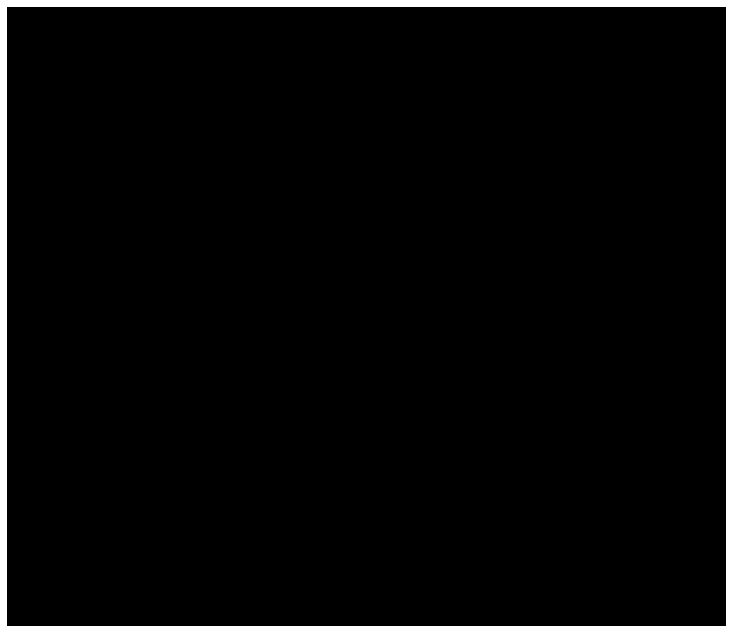

In [6]:
DEAPlotting.animated_timeseries(ds=shifted_ds,
                                output_path=f'animated_shift.mp4',
                                bands=['nbar_red', 'nbar_green', 'nbar_blue'],
                                interval=50,
                                width_pixels=500, 
                                time_dim='shift_x',
                                show_date=False,
                                onebandplot_cbar=False)
